Assignment 2, Practical Part: Question 5 (Transformer Only)

Author: Andrew Williams, 20125276

Unfortunately, due to computational restrictions, the best performing model could not be used: a batch size of 128, rather than 20, was used to alleviate the computational burden. The rest of the hyperparameters are unvaried. Even if this isn't the best performing model, it still leads to some interesting results. 

In [11]:
f = open("exp_config.txt", "r") 
print(f.read())

batch_size    128
code_file    /home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py
data    data
debug    False
dp_keep_prob    0.35
emb_size    200
evaluate    False
hidden_size    512
initial_lr    20
model    TRANSFORMER
num_epochs    40
num_layers    6
optimizer    SGD_LR_SCHEDULE
save_best    True
save_dir    TRANSFORMER_SGD_LR_SCHEDULE_f_runuser1000jupyterkernel-9e85cc7d-145c-4837-9730-235104c6172e.json_32
seed    1111
seq_len    35



In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#load the average losses of the 35 time-steps for each epoch
x = np.load('learning_curves.npy')[()]
y = x['val_timestep_losses_total']


time_steps = pd.DataFrame(np.concatenate(y))

Text(0, 0.5, 'average loss per time-step')

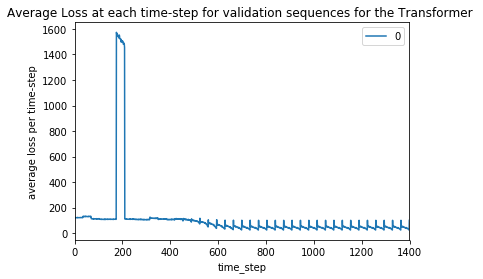

In [13]:
# plt.figure()
# plt.xlabel("time-step")
# plt.ylabel("loss")

whole_plot = time_steps.plot(title="Average Loss at each time-step for validation sequences for the Transformer ")
whole_plot.set_xlabel('time_step')
whole_plot.set_ylabel('average loss per time-step')

This is a very odd-looking plot: let's upper-bound the y-lim to disregard the high spike around the 200th time-step.

Text(0, 0.5, 'average loss per time-step')

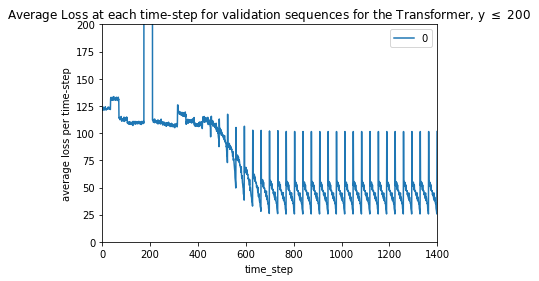

In [21]:
capped_plot = time_steps.plot(title="Average Loss at each time-step for validation sequences for the Transformer, y $\leq$ 200 ", ylim = [0,200])
capped_plot.set_xlabel('time_step')
capped_plot.set_ylabel('average loss per time-step')

The transformer's average loss is initially seen to jump between epochs: the parallelizing of the code explains this. However, it does not explain the upward spike, nor the oscillation at the end. Let's look at the upward spike. 

Text(0, 0.5, 'average loss per time-step')

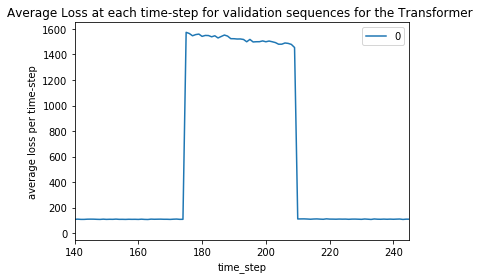

In [15]:
spike_plot = time_steps.plot(title="Average Loss at each time-step for validation sequences for the Transformer, epochs 5 through 7 ", xlim = [4*35,7*35])
spike_plot.set_xlabel('time_step')
spike_plot.set_ylabel('average loss per time-step')

It would seem that the 6th iteration(index 5)'s average loss spikes to 1600. Let's look at the data. 

In [16]:
spike_df = pd.DataFrame(y)
spike_df[3:7]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
3,109.327963,110.244653,109.797205,108.944848,108.705736,110.004345,110.128218,108.733056,108.147342,110.512237,...,109.240257,109.166269,110.353033,108.926984,109.614845,108.931098,109.649937,110.851254,108.279772,109.476347
4,109.130127,110.564979,108.767695,108.814560,110.301558,110.651887,110.405622,109.348940,108.602472,110.549021,...,109.741666,110.185936,110.554383,109.633070,109.662240,108.719917,110.282677,111.283662,109.111209,109.357311
5,1572.585793,1563.447853,1545.723755,1554.993210,1558.877983,1540.990242,1548.301514,1547.461464,1537.710274,1545.662926,...,1498.771355,1504.506851,1498.845917,1492.378906,1479.613533,1479.897736,1489.253777,1486.091698,1478.079170,1453.809692
6,112.068863,112.429638,112.741035,111.589495,110.020236,111.705660,112.424009,110.795049,109.642165,113.029753,...,110.248579,109.712324,110.920788,109.803981,110.792484,109.762464,110.764810,111.536467,108.399995,110.597158


Indeed, it seems that the losses at the 5th epoch are an order of magnitude higher than the previous losses. A reasonable explanation for this behaviour would be exploding gradients: since the initial learning rate is high (~20), it is qutie possible that, early in training, even the attention mechanism could encounter a cliff and have its position on the loss surface shot far away due to a steep cliff. This is surprising though, seeing as one of the attention mechanism's strengths is helping alleviate the exploding gradient problem. Let us move on to look at the oscillation in more detail. 

Text(0, 0.5, 'average loss per time-step')

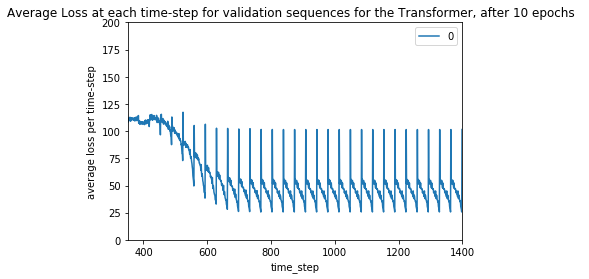

In [20]:
oscillate_plot = time_steps.plot(title="Average Loss at each time-step for validation sequences for the Transformer, after 10 epochs  ", xlim = [10*35,40*35], ylim = [0,200])
oscillate_plot.set_xlabel('time_step')
oscillate_plot.set_ylabel('average loss per time-step')

After the spike, the average loss does seem to decrease, but keeps spiking: let's look at one epoch.

Text(0, 0.5, 'average loss per time-step')

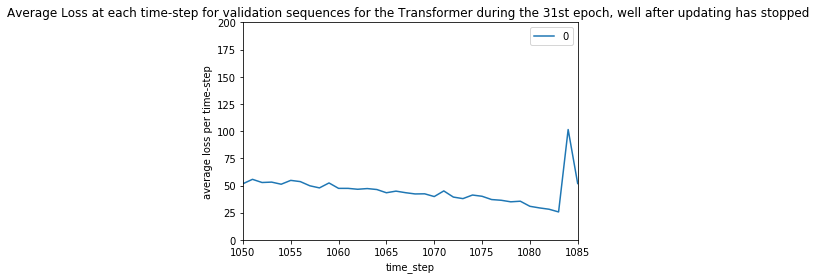

In [19]:
osc_epoch_plot = time_steps.plot(title="Average Loss at each time-step for validation sequences for the Transformer during the 31st epoch, well after updating has stopped ", xlim = [30*35,31*35], ylim=[0,200])
osc_epoch_plot.set_xlabel('time_step')
osc_epoch_plot.set_ylabel('average loss per time-step')

It seems that the model has gotten stuck in a local minima where all but the last word in a sequence have a reasonable value for the loss: this is a consequence of using first-order methods to optimize. A potential solution would be a different initialization, either by changing the seed or the actual values. 

Overall, for the transformer, we can notice drops in the validation loss at each epoch in the beginning. This makes  sense, due to the highly parallelized nature of the model. Around the 6th epoch, the model likely encounters a steep gradient and, due to the high initial learning rate that has yet to taper out, the model shoots across the loss surface, after which is continues to optimize and loss decreases. This occurs until it reaches what is possibly a saddle point or a local minimum and it ends up stabilizing with a sub-60 loss average for every time-step other than the last, which is over 100. After around 20 epochs, the model is no longer making significant progress in its optimization. 

The model also trains much faster time-wise. As in https://arxiv.org/pdf/1706.03762.pdf, when the sequence length is shorter than the representation dimensionality, this provides a considerable speed boost due to this same parallelism of computation. 

The last time-step seems to have a much higher loss than the rest due to getting stuck in a local minimum. Other potential explanations are bugs in the code, or some form of local minimum where the descent gets stuck. 

Unfortunately, due to the missing RNN/GRU component, a comparison cannot be made to the other models. However, it is likely that, due to the updates happening in a less parallelized fashion, a smoother descent of the loss function would be observed. 